<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Look-at-validation-set-and-reshape" data-toc-modified-id="Look-at-validation-set-and-reshape-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Look at validation set and reshape</a></span><ul class="toc-item"><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get predictions</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reshape</a></span></li></ul></li><li><span><a href="#Check-out-energy-conservation" data-toc-modified-id="Check-out-energy-conservation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check out energy conservation</a></span><ul class="toc-item"><li><span><a href="#Get-pressure-diffs" data-toc-modified-id="Get-pressure-diffs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get pressure diffs</a></span></li><li><span><a href="#Continue-with-budgets" data-toc-modified-id="Continue-with-budgets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Continue with budgets</a></span></li></ul></li></ul></div>

# Diagnostics for new predictions

- Understand reshaping
- Find way of loading predictions

In [37]:
# Imports
from losses import metrics
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [28]:
data_dir = '/local/S.Rasp/cbrain_data/'

## Look at validation set and reshape

In [39]:
valid_targets = xr.open_dataset(data_dir + 'valid_year1_targets.nc')
valid_features = xr.open_dataset(data_dir + 'valid_year1_features.nc')

The original dataset was reshaped from [time, lev, lat, lon] to [lev, sample], so sample=time, lat, lon. 

Then sample and lev were transposed to [sample, lev].

In [40]:
# Get first 2 days
n_lon = 128
n_lat = 64
n_geo = n_lat * n_lon
sample_targets = np.array(valid_targets.targets[:2*n_geo, :])
sample_features = np.array(valid_features.features[:2*n_geo, :])

In [41]:
sample_targets.shape, sample_features.shape

((16384, 86), (16384, 87))

### Get predictions

In [38]:
model = keras.models.load_model('./models/001_1year_noshuffle.h5')

In [42]:
preds = model.predict(sample_features)

In [43]:
preds.shape

(16384, 86)

### Reshape 

In [46]:
targets_re = sample_targets.reshape((-1, n_lat, n_lon, sample_targets.shape[-1]))
features_re = sample_features.reshape((-1, n_lat, n_lon, sample_features.shape[-1]))
preds_re = preds.reshape((-1, n_lat, n_lon, preds.shape[-1]))

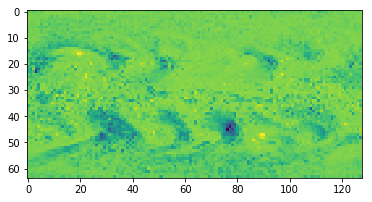

In [49]:
plt.imshow(targets_re[-1, :, :, 20]);

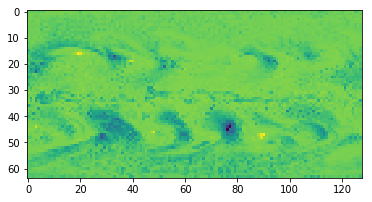

In [50]:
plt.imshow(preds_re[-1, :, :, 20]);

## Check out energy conservation

In [51]:
norm_file = xr.open_dataset(data_dir + 'year0_norm.nc')
norm_file

<xarray.Dataset>
Dimensions:        (feature_lev: 87, target_lev: 86)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * target_lev     (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
Data variables:
    feature_means  (feature_lev) float32 ...
    feature_stds   (feature_lev) float32 ...
    target_means   (target_lev) float32 ...
    target_stds    (target_lev) float32 ...
    feature_names  (feature_lev) object ...
    target_names   (target_lev) object ...
Attributes:
    log:      \n    Time: 2017-11-29T13:01:07\n\n    Executed command:\n\n   ...

In [54]:
features_re_unnorm = (features_re * np.array(norm_file.feature_stds) + 
                      np.array(norm_file.feature_means))

In [68]:
norm_file.feature_names[-2].values

array('LHFLX',
      dtype='<U5')

In [194]:
norm_file.target_names[21:42].values, norm_file.target_names[-2].values, norm_file.target_names[:21].values

(array(['SPDQ_lev09', 'SPDQ_lev10', 'SPDQ_lev11', 'SPDQ_lev12',
        'SPDQ_lev13', 'SPDQ_lev14', 'SPDQ_lev15', 'SPDQ_lev16',
        'SPDQ_lev17', 'SPDQ_lev18', 'SPDQ_lev19', 'SPDQ_lev20',
        'SPDQ_lev21', 'SPDQ_lev22', 'SPDQ_lev23', 'SPDQ_lev24',
        'SPDQ_lev25', 'SPDQ_lev26', 'SPDQ_lev27', 'SPDQ_lev28', 'SPDQ_lev29'], dtype=object),
 array('PRECT',
       dtype='<U5'),
 array(['SPDT_lev09', 'SPDT_lev10', 'SPDT_lev11', 'SPDT_lev12',
        'SPDT_lev13', 'SPDT_lev14', 'SPDT_lev15', 'SPDT_lev16',
        'SPDT_lev17', 'SPDT_lev18', 'SPDT_lev19', 'SPDT_lev20',
        'SPDT_lev21', 'SPDT_lev22', 'SPDT_lev23', 'SPDT_lev24',
        'SPDT_lev25', 'SPDT_lev26', 'SPDT_lev27', 'SPDT_lev28', 'SPDT_lev29'], dtype=object))

In [57]:
# Define conversion dict
L_V = 2.5e6   # Latent heat of vaporization is actually 2.26e6
C_P = 1e3 # Specific heat capacity of air at constant pressure
conversion_dict = {
    'SPDT': C_P,
    'SPDQ': L_V,
    'QRL': C_P,
    'QRS': C_P,
    'PRECT': 1e3*24*3600 * 1e-3,
    'FLUT': 1. * 1e-5,
}

In [107]:
# Moisture energy budget
spdq_vint = np.mean(targets_re[:, :, :, 21:42], axis=-1)
precip = targets_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3
evap = features_re_unnorm[:, :, :, -2]

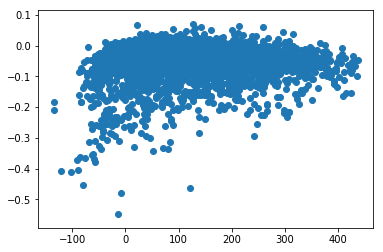

In [72]:
plt.scatter(evap-precip, spdq_vint)

### Get pressure diffs

In [125]:
aqua_file = xr.open_dataset('/project/meteo/w2w/A6/S.Rasp/SP-CAM/Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0001-01-01-00000.nc', decode_times=False)

In [126]:
aqua_file

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 365.0 365.0 365.0 365.1 365.1 365.1 365.1 ...
Dimensions 

In [127]:
aqua_file.hyam.values

array([ 0.00364347,  0.00759482,  0.01435663,  0.02461222,  0.0382683 ,
        0.05459548,  0.07201245,  0.08782123,  0.10331713,  0.12154724,
        0.14299404,  0.16822508,  0.17823067,  0.17032433,  0.16102291,
        0.15008029,  0.13720686,  0.12206194,  0.10424471,  0.08497915,
        0.0665017 ,  0.05019679,  0.03718866,  0.02843195,  0.02220898,
        0.01640738,  0.01107456,  0.00625495,  0.00198941,  0.        ])

In [128]:
pressure = aqua_file.P0 * aqua_file.hyai + aqua_file.PS * aqua_file.hybi

In [129]:
pressure

<xarray.DataArray (ilev: 31, time: 48, lat: 64, lon: 128)>
array([[[[    225.523952, ...,     225.523952],
         ..., 
         [    225.523952, ...,     225.523952]],

        ..., 
        [[    225.523952, ...,     225.523952],
         ..., 
         [    225.523952, ...,     225.523952]]],


       ..., 
       [[[ 101968.515625, ...,  101966.070312],
         ..., 
         [  98747.460938, ...,   98720.898438]],

        ..., 
        [[ 102042.195312, ...,  102042.085938],
         ..., 
         [  99010.703125, ...,   98994.695312]]]])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * time     (time) float64 365.0 365.0 365.0 365.1 365.1 365.1 365.1 365.1 ...

In [130]:
p_mean = np.mean(pressure.values, axis=(1,2,3))

In [131]:
p_mean

array([   225.52395239,    503.16918641,   1015.79474284,   1855.53170741,
         3066.91229343,   4586.74766118,   6332.34828711,   8070.14182202,
         9494.10423647,  11169.32109009,  13140.1270628 ,  15458.68068919,
        18186.33526545,  21340.5779413 ,  25051.38098093,  29416.94868847,
        34552.81440728,  40594.88957008,  47703.08287608,  56065.50228631,
        64431.2693192 ,  72109.39951014,  78588.74585216,  83404.28929946,
        86192.15916023,  88807.67469634,  91229.65330682,  93438.13868687,
        95414.49170885,  97141.88996045,  98609.97653083])

In [132]:
p_diff = np.diff(pressure.values, axis=0)[9:]
p_diff = np.rollaxis(p_diff, 0, 4)

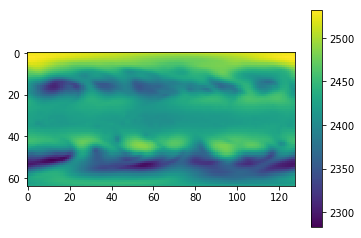

In [155]:
plt.imshow(p_diff[10, :, :, -5])
plt.colorbar()

In [225]:
x_data = aqua_file.SPDQ.values * np.rollaxis(np.diff(pressure.values, axis=0), 0, 2) * L_V / 9.81

In [226]:
x_data = np.sum(x_data, axis=1)[1:3]

In [227]:
y_data = aqua_file.LHFLX.values[:2] - aqua_file.PRECT.values[1:3] * 1e3 * L_V 

In [228]:
x_data.shape, y_data.shape

((2, 64, 128), (2, 64, 128))

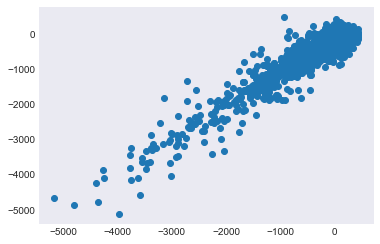

In [229]:
plt.scatter(np.ravel(y_data), np.ravel(x_data))

### Continue with budgets

In [140]:
p_diff.shape, targets_re[:, :, :, 21:42].shape

((48, 64, 128, 21), (2, 64, 128, 21))

In [187]:
spdq_vint = np.sum(targets_re[:, :, :, 21:42] * p_diff[:2], axis=-1) / 9.81
spdt_vint = np.sum(targets_re[:, :, :, :21] * p_diff[:2], axis=-1) / 9.81
precip = targets_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3
evap = features_re_unnorm[:, :, :, -2]
sens = features_re_unnorm[:, :, :, -3]

In [188]:
spdq_preds_vint = np.sum(preds_re[:, :, :, 21:42] * p_diff[:2], axis=-1) / 9.81
spdt_preds_vint = np.sum(preds_re[:, :, :, :21] * p_diff[:2], axis=-1) / 9.81
precip_preds = preds_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3

In [189]:
import seaborn as sns
sns.set_style('dark')

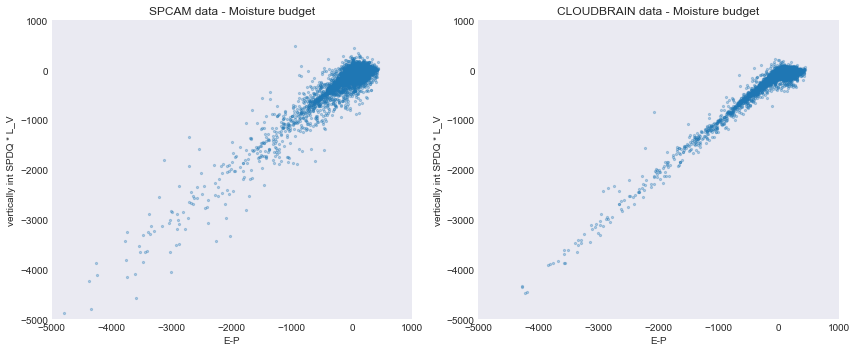

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, name, p, s in zip(
    [0, 1],
    ['SPCAM', 'CLOUDBRAIN'],
    [precip, precip_preds],
    [spdq_vint, spdq_preds_vint],
):
    axes[i].scatter(evap-p, s, s=5, alpha=0.3)
    axes[i].set_xlabel('E-P')
    axes[i].set_ylabel('vertically int SPDQ * L_V')
    axes[i].set_title(name + ' data - Moisture budget')
    axes[i].set_xlim(-5000, 1000)
    axes[i].set_ylim(-5000, 1000)
plt.tight_layout()

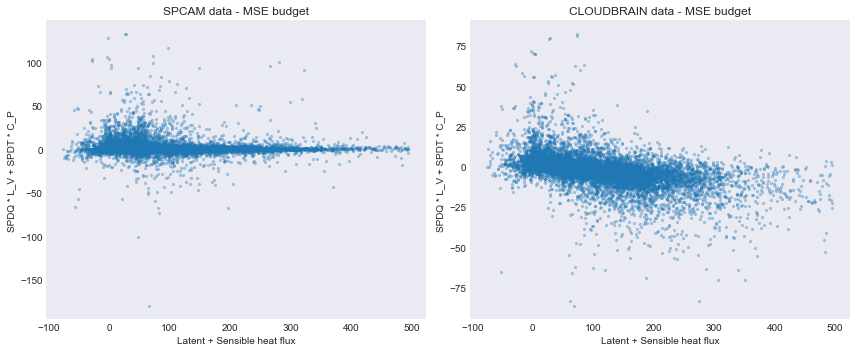

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, name, p, sq, st in zip(
    [0, 1],
    ['SPCAM', 'CLOUDBRAIN'],
    [precip, precip_preds],
    [spdq_vint, spdq_preds_vint],
    [spdt_vint, spdt_preds_vint],
):
    axes[i].scatter(evap+sens, st+sq, s=5, alpha=0.3)
    axes[i].set_xlabel('Latent + Sensible heat flux')
    axes[i].set_ylabel('SPDQ * L_V + SPDT * C_P')
    axes[i].set_title(name + ' data - MSE budget')
plt.tight_layout()